# Fashion MNIST 예제

1. **먼저 필요한 패키지와 라이브러리를 불러옵니다.**

In [31]:
import numpy as np
import pandas as pd
import tensorflow as tf

2. **데이터셋을 불러온 후 학습 데이터셋(Train Dataset)과 시험 데이터셋(Test Dataset)으로 나누어(Split)주고 픽셀값을 정규화 하여줍니다.**

In [32]:
from tensorflow.keras.datasets import fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [33]:
print(X_train.shape, X_test.shape)

(60000, 28, 28) (10000, 28, 28)


In [34]:
X_train, X_test = X_train / 255.0, X_test / 255.0

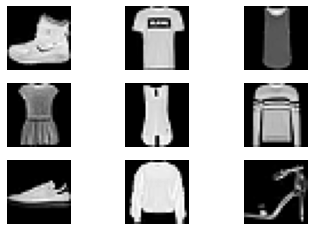

In [35]:
import matplotlib.pyplot as plt

for i in range(9):
    plt.subplot(3, 3, i+1)
    
    plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
    plt.axis('off')
    
plt.show()

3. **레이블이 어떻게 구성되어 있는 지 확인해봅니다.**

    데이터의 레이블 구성 형태를 살펴봅니다.<br/>
    처음보는 데이터의 경우 데이터 자체를 디스플레이 하여 보면 도움이 됩니다.

4. **이제 본격적으로 신경망 모델을 구축해보겠습니다.**

> ❗️ ***아래 코드에서 출력층의 노드 수는 몇 개인지, 출력층의 활성화 함수는 무엇인지, 손실 함수는 어떻게 지정하였는지에 주목해봅시다.***<br/>
❗️ ***`.summary()`를 활용하면 모델의 구조를 빠르게 파악해 볼 수 있습니다.***

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

model = Sequential() 
model.add(Flatten(input_shape=(28, 28)))
model.add(Dense(10, activation='softmax'))

In [37]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [39]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.6027 - accuracy: 0.7972
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4607 - accuracy: 0.8437
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.4356 - accuracy: 0.8500
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4222 - accuracy: 0.8544
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4138 - accuracy: 0.8566
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4073 - accuracy: 0.8596
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4018 - accuracy: 0.8610
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3976 - accuracy: 0.8626
Epoch 9/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3950 - accuracy: 0.8633
Epoch 10/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.391

5. **학습한 신경망 모델을 사용하여 평가합니다.**

In [40]:
model.evaluate(X_test,  y_test, verbose=2)

313/313 - 1s - loss: 0.4426 - accuracy: 0.8453 - 637ms/epoch - 2ms/step


[0.44264593720436096, 0.845300018787384]

생각해볼것

손글씨 MNIST 예제 코드에서

 1. **`Flatten`** 은 어떤 역할을 할까요? <br/>
 2. 마지막 **`Dense`** 층의 숫자는 왜 **10** 일까요? <br/>
 3. 마지막 **`Dense`** 층의 **`activation`** 은 왜 **`softmax`** 로 해주었을까요? <br/>
 4. **`compile`** 이 있는 부분에서 **`loss`** 함수는 왜 **`sparse_categorical_crossentropy`** 로 해준 것일까요?


# 역전파(Backpropagation, BP)

**`공부시간`** 과 **`수면시간`** 을 특성(Feature)으로 하고 시험 점수를 레이블로 하는 회귀 예제를 풀어봅시다.<br/>
데이터에서 특성과 레이블은 아래와 같은 선형 관계를 이루고 있다고 가정하겠습니다.<br/>
아래 식에서 $x_1$ 은 **`공부시간`**을 나타내고 $x_2$ 는 **`수면시간`**을 나타낸다고 해보겠습니다.

$y = 5x_1 + 2x_2 + 40$

그리고 신경망이 위 관계를 알아서 잘 찾아낼 수 있는지를 알아보겠습니다.

1. **필요한 패키지를 `import` 하고 랜덤 시드(random seed)를 고정합니다.**

In [1]:
# 해당 코드는 선형함수를 예측하는 예제입니다. 
import numpy as np

np.random.seed(812)

2. **임의의 특성 데이터로부터 관계를 만족하는 레이블을 도출한 뒤에 데이터셋을 만듭니다.**

In [2]:
# [공부시간, 수면시간]
X = np.array(([8,8],
              [2,5],
              [7,6]), dtype=float)

# 선형 관계를 바탕으로 시험 점수 레이블을 생성합니다.
y = X[:,0]*5 + X[:,1]*2
y = y.reshape(3,1)

3. **특성을 정규화(Normalization) 합니다.**

각 특성 및 레이블의 최댓값으로 나누어 주어 0~1 사이의 값으로 만들어줍니다.

In [3]:
X = X / np.amax(X, axis=0)
y = y / np.amax(y, axis=0)

print("공부시간, 수면시간 \n", X)
print("시험점수 \n", y)

공부시간, 수면시간 
 [[1.    1.   ]
 [0.25  0.625]
 [0.875 0.75 ]]
시험점수 
 [[1.        ]
 [0.35714286]
 [0.83928571]]


4. **신경망을 구축합니다.**

`NeuralNetwork` 클래스 내 `__init__` 메소드(함수)에서 신경망을 구축합니다.

In [4]:
class NeuralNetwork:
    """
    신경망(Neural network)를 정의하는 클래스(Class) 선언
    """
    def __init__(self):
        """
        신경망의 구조를 결정합니다.

        inputs : 입력층 노드 수
        hiddenNodes : 은닉층 노드 수
        outputNodes : 출력층 노드 수
        w1, w2 : 은닉층(layer 1), 출력층(layer 2)의 가중치
        """
        
        self.inputs = 2
        self.hiddenNodes = 3
        self.outputNodes = 1
        
        # 가중치를 초기화 합니다.
        # layer 1 가중치 shape : 2x3
        self.w1 = np.random.randn(self.inputs,self.hiddenNodes)
        
        # layer 2 가중치 shape : 3x1
        self.w2 = np.random.randn(self.hiddenNodes, self.outputNodes)

In [5]:
# 정의된 클래스를 사용해보고, 해당 가중치를 디스플레이 하는 코드입니다. 
nn = NeuralNetwork()

print("Layer 1 가중치: \n", nn.w1)
print("Layer 2 가중치: \n", nn.w2)

Layer 1 가중치: 
 [[ 2.48783189  0.11697987 -1.97118428]
 [-0.48325593 -1.50361209  0.57515126]]
Layer 2 가중치: 
 [[-0.20672583]
 [ 0.41271104]
 [-0.57757999]]


5. **순전파 기능을 추가로 구현합니다.**

**기존 `NeuralNetwork` 클래스에 순전파 기능을 추가**하여 봅시다.<br/>
순전파에 필요한 활성화 함수(sigmoid)를 구현한 뒤에 가중합(weighted sum)부분과 활성화 함수가 적용되는 부분을 구현합니다.

In [6]:
class NeuralNetwork:
    
    def __init__(self):
        """
        신경망의 구조를 결정합니다.

        inputs : 입력층 노드 수
        hiddenNodes : 은닉층 노드 수
        outputNodes : 출력층 노드 수
        w1, w2 : layer 1, layer 2의 가중치
        """
        self.inputs = 2
        self.hiddenNodes = 3
        self.outputNodes = 1
        
        # 가중치를 초기화 합니다.
        # layer 1 가중치 shape : 2x3
        self.w1 = np.random.randn(self.inputs,self.hiddenNodes)
        
        # layer 2 가중치 shape : 3x1
        self.w2 = np.random.randn(self.hiddenNodes, self.outputNodes)
        
    def sigmoid(self, s):
        """
        활성화 함수인 시그모이드 함수를 정의합니다.
        s : 활성화 함수에 입력되는 값(=가중합)
        """
        return 1 / (1+np.exp(-s))
    
    def feed_forward(self, X):
        """
        순전파를 구현합니다.
        입력 신호를 받아 출력층의 결과를 반환합니다.
        
        hidden_sum : 은닉층(layer 1)에서의 가중합(weighted sum)
        activated_hidden : 은닉층(layer 1) 활성화 함수의 함숫값
        output_sum : 출력층(layer 2)에서의 가중합(weighted sum)
        activated_output : 출력층(layer 2) 활성화 함수의 함숫값
        """
        
        self.hidden_sum = np.dot(X, self.w1)
        self.activated_hidden = self.sigmoid(self.hidden_sum)

        self.output_sum = np.dot(self.activated_hidden, self.w2)
        self.activated_output = self.sigmoid(self.output_sum)
        
        return self.activated_output

6. **순전파를 거쳐 출력되는 값을 알아봅시다.**

입력한 데이터가 신경망 순전파를 거쳐 어떤 출력값을 내는 지 확인해봅니다.

In [7]:
# 선언한 클래스를 불러와서 할당합니다.
nn = NeuralNetwork()

In [8]:
# 첫 번째 데이터를 출력합니다.
print(X[0])

[1. 1.]


In [9]:
# 첫 번째 데이터를 입력한 뒤 신경망이 출력하는 값을 살펴보겠습니다.
output = nn.feed_forward(X[0])
print("예측값: ", output)

예측값:  [0.21945787]


7. **손실(Error,Loss)과 비용(Cost) 계산**

1개의 데이터에 대해 실제 타겟 레이블과 출력값을 비교하여 손실(`error`)을 구해봅니다.

In [10]:
# 실제 타겟 레이블과 출력값을 비교하여 손실(error)을 구합니다.
error = y[0] - output
error

array([0.78054213])

이 과정을 모든 데이터에 적용하여 비용(Cost)를 구해봅시다.

In [11]:
# 모든 데이터를 예측해보고 에러값을 계산해 보겠습니다.
print(X)

[[1.    1.   ]
 [0.25  0.625]
 [0.875 0.75 ]]


In [12]:
output_all = nn.feed_forward(X)
print(output_all)

[[0.21945787]
 [0.34573206]
 [0.23788921]]


In [13]:
error_all = y - output_all
print(error_all)

[[0.78054213]
 [0.0114108 ]
 [0.6013965 ]]


#### 결과값 분석

1. 각각의 **에러가 작어야 하는데 너무 크게 나왔습니다.** 에러가 크게 나오는 이유는 무엇일까요?
    - 에러가 높게 나오는 이유는 예측값이 **정확하지 않기(여기서는 너무 작게 나오기) 때문**입니다.

2. 그렇다면 **예측값이 작게 나오는 이유**는 무엇일까요?
    - 임의로 지정하였던 두 번째 층의 가중치 값(`w2`)이 작거나
    - 첫 번째 층의 출력값(`activated_hidden`)이 작기 때문입니다.

3. **첫 번째 층의 출력값(`activated_hidden`)이 작은 이유**는 무엇일까요?
- 입력 데이터(`X`)는 변하지 않는 값이므로 첫 번째 층의 가중치 값(`w1`)이 작기 때문입니다.

**1, 2, 3**을 고려했을 때 예측값을 증가시키기 위한 방법은 **첫 번째 층과 두 번째 층의 가중치(`w1, w2`)를 증가시키는 것**뿐입니다.

이렇게 각 층마다 가중치가 있을텐데 에러를 최소화하기 위해서 어떤 가중치를 얼마나 올려주어야 할까요?<br/>
일단 각 층의 가중치를 출력해보겠습니다.

In [14]:
# 각각의 변수(가중치)를 디스플레이 하기 위한 코드입니다.
attributes = ['w1', 'hidden_sum', 'activated_hidden', 'w2', 'activated_output']

for i in attributes:
    if i[:2] != '__':
        print(i+'\n', getattr(nn,i), '\n'+'---'*3)

w1
 [[-1.75351135  1.23279898  0.24464757]
 [-0.06568225  0.30190098  0.79723428]] 
---------
hidden_sum
 [[-1.8191936   1.53469996  1.04188185]
 [-0.47942924  0.49688786  0.55943332]
 [-1.58358412  1.30512484  0.81199233]] 
---------
activated_hidden
 [[0.13953066 0.82269293 0.73921295]
 [0.38238691 0.62172769 0.63632141]
 [0.17028848 0.78669622 0.6925339 ]] 
---------
w2
 [[ 1.23073545]
 [-1.52187331]
 [-0.25502715]] 
---------
activated_output
 [[0.21945787]
 [0.34573206]
 [0.23788921]] 
---------


#### 손실(Error)을 줄이기 위해서는 어떻게 해야 할까요?

아래 그림을 보면 알 수 있듯, **비용 함수 $J$ 의 경사(Gradient)가 작아지는 방향으로 업데이트** 하면 손실 함수의 값을 줄일 수 있습니다.<br/>
매 Iteration 마다 **<font color="ff6f61">해당 가중치에서의 비용 함수의 도함수(=비용 함수를 미분한 함수)를 계산</font>하여** 경사가 작아질 수 있도록 가중치를 변경합니다.

<img src="https://i.imgur.com/ehYYRtw.png" alt="Gradient Descent in 1D" width="700"/>

위에서 설계한 신경망은 총 9개의 가중치를 가지고 있습니다. 첫 번째 층에는 6개(`w1`), 두 번째 층에는 3개(`w2`)가 있죠.<br/>
그렇기 때문에 해당 신경망의 비용 함수는 9차원 공간상의 함수$(J)$가 되겠습니다.<br/>
비용 함수의 경사가 줄어드는 방향으로 가중치를 갱신해나가면 되겠죠?

비용 함수 $J$를 수식으로 나타내 보겠습니다.

$$
J(\theta) = J(\theta_1, \theta_2, \theta_3, \theta_4, \theta_5, \theta_6, \theta_7, \theta_8, \theta_9)
$$

아래는 비용 함수를 가중치 2개에 대해서만 단순화시켜 나타낸 그림입니다.

<img src="https://i.imgur.com/yZA6RUJ.png" alt="Gradient descent algorithm direction Equation 1. (Image courtesy of Andrew Ng)" width="600"/>

- **볼록/오목 함수(Convex/Concave function)와 지역 최적점(Local Optima)**

경사 하강법을 통해 최저점을 찾는 메커니즘은 볼록(Convex) 함수에서만 잘 동작합니다.<br/>
하지만 실제 손실 함수는 위 그림처럼 볼록 함수와 오목 함수가 부분부분 섞여있는 형태인데요.<br/>
그렇기 때문에 전역 최적점(Global Optima)를 찾지 못하고 **지역 최적점(Local Optima)에 빠질 수 있습니다.**

지역 최적점에 빠지게 되는 문제를 방지하기 위한 여러가지 방법있습니다.

### 가중치 업데이트 : 역전파 

6. **<font color="ff6f61">역전파 기능을 구현</font>해봅시다.**



In [16]:
# 음수 가중치를 가지는 활성화는 낮추고, 양수 가중치를 가지는 활성화는 높이고 싶습니다.
class NeuralNetwork:
    
    def __init__(self):
        """
        신경망의 구조를 결정합니다.

        inputs : 입력층 노드 수
        hiddenNodes : 은닉층 노드 수
        outputNodes : 출력층 노드 수
        w1, w2 : layer 1, layer 2의 가중치
        """
        self.inputs = 2
        self.hiddenNodes = 3
        self.outputNodes = 1
        
        # 가중치를 초기화 합니다.
        # layer 1 가중치 shape : 2x3
        self.w1 = np.random.randn(self.inputs,self.hiddenNodes)
        
        # layer 2 가중치 shape : 3x1
        self.w2 = np.random.randn(self.hiddenNodes, self.outputNodes)
        
    def sigmoid(self, s):
        """
        활성화 함수인 시그모이드 함수를 정의합니다.
        s : 순전파 과정에서 활성화 함수에 입력되는 값(=가중합)
        """
        return 1 / (1+np.exp(-s))

    def sigmoidPrime(self, s):
        """
        활성화 함수(sigmoid)를 미분한 함수입니다.
        s : 순전파 과정에서 활성화 함수에 입력되는 값(=가중합)
        """
        sx = self.sigmoid(s)
        return sx * (1-sx)
    
    def feed_forward(self, X):
        """
        순전파를 구현합니다.
        입력 신호를 받아 출력층의 결과를 반환합니다.
        
        hidden_sum : 은닉층(layer 1)에서의 가중합(weighted sum)
        activated_hidden : 은닉층(layer 1) 활성화 함수의 함숫값
        output_sum : 출력층(layer 2)에서의 가중합(weighted sum)
        activated_output : 출력층(layer 2) 활성화 함수의 함숫값
        """
        
        self.hidden_sum = np.dot(X, self.w1)
        self.activated_hidden = self.sigmoid(self.hidden_sum)

        self.output_sum = np.dot(self.activated_hidden, self.w2)
        self.activated_output = self.sigmoid(self.output_sum)
        
        return self.activated_output
    
    def backward(self, X, y, o):
        """
        역전파를 구현합니다.
        출력층에서 손실 값(Error)를 구한 뒤에 이를 각 가중치에 대해 미분한 값만큼 가중치를 수정합니다.

        X : 입력 데이터(input)
        y : 타겟값(target value)
        o : 출력값(output)

        o_error : 손실(Error) = 타겟값과 출력값의 차이
        o_delta : 출력층 활성화 함수의 미분값
        """
        
        # o_error : 손실(Error)을 구합니다.
        self.o_error = y - o 
        
        # o_delta : 활성화 함수(시그모이드)의 도함수를 사용하여 출력층 활성화 함수 이전의 미분값을 구합니다.
        self.o_delta = self.o_error * self.sigmoidPrime(o)
        
        # z2 error : 은닉층에서의 손실을 구합니다.
        self.z2_error = self.o_delta.dot(self.w2.T)
        
        # z2 delta : 활성화 함수(시그모이드)의 도함수를 사용하여 은닉층 활성화 함수 이전의 미분값을 구합니다.
        self.z2_delta = self.z2_error*self.sigmoidPrime(self.output_sum)

        # w1, w2를 업데이트 합니다.
        self.w1 += X.T.dot(self.z2_delta) # X * dE/dY * dY/dy(=Y(1-Y))
        self.w2 += self.activated_hidden.T.dot(self.o_delta) # H1 * Y(1-Y) * (Y - o)
        
    def train(self, X, y):
        """
        실제로 신경망 학습을 진행하는 코드입니다.
        1번의 순전파-역전파, 즉 1 iteration 을 수행하는 함수입니다.
        
        X : 입력 데이터(input)
        y : 타겟값(target value)
        """
        o = self.feed_forward(X)
        self.backward(X,y,o)

- 수식을 통해 위 코드를 알아보겠습니다.

    손실(Error) : $E$<br/>
출력층 활성화 함수의 출력값(`activated_output`) : $A_O$<br/>
출력층 활성화 함수의 입력값(=가중합, `output_sum`) : $S_O$<br/>
은닉층 활성화 함수의 출력값(`activated_hidden`) : $A_H$<br/>
은닉층 활성화 함수의 입력값(=가중합, `hidden_sum`) : $S_H$

- **$w_2$(=출력층과 은닉층 사이의 가중치) 에 대한 미분**

$$
\begin{aligned}
\frac{\partial E}{\partial w_2} &= \frac{\partial E}{\partial A_O} \cdot \frac{\partial A_O}{\partial w_2}\\
\frac{\partial E}{\partial w_2} &= \frac{\partial E}{\partial A_O} \cdot 
\frac{\partial A_O}{\partial S_O} \cdot \frac{\partial S_O}{\partial w_2}
= \frac{\partial E}{\partial A_O} \cdot 
\frac{\partial A_O}{\partial S_O} \cdot A_H \quad \bigg( \because A_H = \frac{\partial S_O}{\partial w_2}\bigg)
\end{aligned}
$$


- **$w_1$(=은닉층과 입력층 사이의 가중치) 에 대한 미분**

$$
\begin{aligned}
\frac{\partial E}{\partial w_1} &= \frac{\partial E}{\partial A_H} \cdot \frac{\partial A_H}{\partial w_1}\\
\frac{\partial E}{\partial w_2} &= \frac{\partial E}{\partial A_H} \cdot 
\frac{\partial A_H}{\partial S_H} \cdot \frac{\partial S_H}{\partial w_1}
= \frac{\partial E}{\partial A_H} \cdot 
\frac{\partial A_H}{\partial S_H} \cdot X \quad \bigg( \because X = \frac{\partial S_H}{\partial w_1}\bigg)
\end{aligned}
$$



#### 역전파가 추가된 신경망 클래스 학습
- **순전파 후 손실(Error) 계산**

In [17]:
nn = NeuralNetwork()
nn.train(X,y)

In [18]:
# 순전파 후 손실(Error)을 확인해보겠습니다.
nn.o_error

array([[0.70644301],
       [0.10036169],
       [0.56649547]])

- **출력층의 경사(Gradient) 계산하기**

**에러(Error, `o_error`)**와 **출력층 활성화 함수를 미분한 함수(`sigmoidPrime`)**를 통해서 출력층의 경사(`o_delta`)를 구해보겠습니다.

`self.o_delta = self.o_error * self.sigmoidPrime(self.output_sum)`

In [19]:
# 순전파 시 출력층에서의 가중합
nn.o_error

array([[0.70644301],
       [0.10036169],
       [0.56649547]])

In [20]:
# 순전파 시 출력층에서의 가중합을 활성화 함수에 통과시킨 
nn.sigmoidPrime(nn.o_error)

array([[0.22123085],
       [0.24937153],
       [0.23096866]])

In [21]:
# 출력층 활성화 함수 이전의 미분값을 구합니다.
# o_delta = o_error * sigmoidPrime(o)
nn.o_delta

array([[0.17285985],
       [0.02468133],
       [0.13902149]])

- **은닉층이 받는 손실(Error) 계산**
이전 단계에서 구했던 **출력층의 경사(`o_delta`)**와 **출력층의 가중치(`w2`)**를 통해서 은닉층이 받는 손실(`z2_error`)을 구해보겠습니다.

`self.z2_error = self.o_delta.dot(self.w2.T)`

In [22]:
nn.o_delta.dot(nn.w2.T)

array([[-0.28194591, -0.23236088,  0.12295841],
       [-0.04025689, -0.03317703,  0.01755629],
       [-0.22675329, -0.18687483,  0.09888856]])

- **은닉층의 경사(Gradient) 계산하기**
**은닉층 에러(`z2_error`)**와 **은닉층 활성화 함수를 미분한 함수(`sigmoidPrime`)**를 통해서 은닉층의 경사(`z2_delta`)를 구해보겠습니다.

`self.z2_delta = self.z2_error * self.sigmoidPrime(self.activated_hidden)`

In [23]:
nn.activated_hidden

array([[0.43460965, 0.23985861, 0.42340322],
       [0.37111212, 0.48687214, 0.52242758],
       [0.48093658, 0.2520165 , 0.4192448 ]])

In [24]:
nn.z2_delta

array([[-0.06388859, -0.05136035,  0.020324  ],
       [-0.00839476, -0.00674859,  0.00267051],
       [-0.04915074, -0.03951252,  0.01563565]])

In [25]:
X.T.shape == nn.w1.shape

True

In [26]:
nn.z2_delta

array([[-0.06388859, -0.05136035,  0.020324  ],
       [-0.00839476, -0.00674859,  0.00267051],
       [-0.04915074, -0.03951252,  0.01563565]])

#### 경사 하강법(Gradient Descent)을 적용하여 가중치 업데이트
- 은닉층 가중치(`w1`)를 업데이트 합니다.


In [27]:
X.T


array([[1.   , 0.25 , 0.875],
       [1.   , 0.625, 0.75 ]])

In [28]:
X.T.dot(nn.z2_delta)

array([[-0.10899418, -0.08762095,  0.03467281],
       [-0.10599837, -0.0852126 ,  0.0337198 ]])

- 출력층 가중치(`w2`)를 업데이트 합니다.

In [29]:
nn.activated_hidden.T.dot(nn.o_delta)

array([[0.15114662],
       [0.08851428],
       [0.14436766]])

### 신경망 학습
이제 순전파와 역전파를 정해진 횟수(iterations or epochs)만큼 반복하여 신경망을 학습시켜 보겠습니다.

In [30]:
nn = NeuralNetwork()

# 반복수(epochs or iterations)를 정합니다.
iter = 10000

# 지정한 반복수 만큼 반복합니다.
for i in range(iter):
    if (i+1 in [1,2,3,4,5]) or ((i+1) % 1000 == 0):
        print('+' + '---' * 3 + f'EPOCH {i+1}' + '---'*3 + '+')
        print('입력: \n', X)
        print('타겟출력: \n', y)
        print('예측: \n', str(nn.feed_forward(X)))
        print("에러: \n", str(np.mean(np.square(y - nn.feed_forward(X)))))
    nn.train(X,y)

+---------EPOCH 1---------+
입력: 
 [[1.    1.   ]
 [0.25  0.625]
 [0.875 0.75 ]]
타겟출력: 
 [[1.        ]
 [0.35714286]
 [0.83928571]]
예측: 
 [[0.37768395]
 [0.40886333]
 [0.39684567]]
에러: 
 0.19523515397548788
+---------EPOCH 2---------+
입력: 
 [[1.    1.   ]
 [0.25  0.625]
 [0.875 0.75 ]]
타겟출력: 
 [[1.        ]
 [0.35714286]
 [0.83928571]]
예측: 
 [[0.45734397]
 [0.47891087]
 [0.47278046]]
에러: 
 0.14787637084266458
+---------EPOCH 3---------+
입력: 
 [[1.    1.   ]
 [0.25  0.625]
 [0.875 0.75 ]]
타겟출력: 
 [[1.        ]
 [0.35714286]
 [0.83928571]]
예측: 
 [[0.52094752]
 [0.53342462]
 [0.5325371 ]]
에러: 
 0.11822041803732024
+---------EPOCH 4---------+
입력: 
 [[1.    1.   ]
 [0.25  0.625]
 [0.875 0.75 ]]
타겟출력: 
 [[1.        ]
 [0.35714286]
 [0.83928571]]
예측: 
 [[0.57039035]
 [0.57514949]
 [0.57861702]]
에러: 
 0.10001317226025601
+---------EPOCH 5---------+
입력: 
 [[1.    1.   ]
 [0.25  0.625]
 [0.875 0.75 ]]
타겟출력: 
 [[1.        ]
 [0.35714286]
 [0.83928571]]
예측: 
 [[0.60862211]
 [0.60709769]
 [0.6141049

출력 결과로 반복 수가 1-5회일 때의 에러와 이후 1000회 마다의 에러를 볼 수 있는데요.<br/>
점점 에러가 줄어드는 경향성을 보이는 것을 확인할 수 있습니다 :)